# Vairous Definitions of Chemical Potential

In [1]:
import numpy as np

from exogibbs.presets.ykb4 import _load_molname, _load_gibbs_matrix
from exogibbs.presets.fastchem import _parse_fastchem_coeffs
from exogibbs.io.load_data import get_data_filepath

# JANAF presets
df_molname = _load_molname()
gibbs_matrices = _load_gibbs_matrix()


T_h_table = gibbs_matrices["H1"]['T(K)'].to_numpy()
T_h2_table = gibbs_matrices["H2"]['T(K)'].to_numpy()

## uses delta-f G as chemical potential Smith & Missen 3-12.2
kJtoJ = 1000.0
mu_h_table = gibbs_matrices["H1"]['delta-f G'].to_numpy() * kJtoJ #J/mol
mu_h2_table = gibbs_matrices["H2"]['delta-f G'].to_numpy() * kJtoJ  #J/mol

# fastchem
path_fastchem_data = get_data_filepath("fastchem/logK/logK.dat")
coeff, comp = _parse_fastchem_coeffs(open(path_fastchem_data, "r", encoding="utf-8").read())

$\mu^\circ (T) = \Delta_f G(T)$ (delta-f G)

In [2]:
#gets index at T_h_table = 298.15
index_h = np.where(np.isclose(T_h_table, 298.15))[0][0]
index_h2 = np.where(np.isclose(T_h2_table, 298.15))[0][0]
T_h_table[index_h], T_h2_table[index_h2]

(298.15, 298.15)

$\mu^\circ (T) = - T \left( - \frac{G^\circ (T) - H_{298}^\circ}{T} \right) + \Delta H_{f, 298}^\circ$   (FEF)

See also https://github.com/dzesmin/TEA/blob/0ec66410f274d9deea7764d53d6363f9aaad3355/tea/makeheader.py#L198

In [3]:

# computes chemical potential from Free Energy Function Smith & Missen 3.12-5a
fef_h_table = gibbs_matrices["H1"]['-[G-H(Tr)]/T'].to_numpy() #J/K/mol
fef_h2_table = gibbs_matrices["H2"]['-[G-H(Tr)]/T'].to_numpy() #J/K/mol

dHf_h_298 = gibbs_matrices["H1"]['delta-f H'].to_numpy()[index_h] * kJtoJ #J/mol
dHf_h2_298 = gibbs_matrices["H2"]['delta-f H'].to_numpy()[index_h2] * kJtoJ #J/mol


mu_fef_h_table = -T_h_table * fef_h_table  + dHf_h_298
mu_fef_h2_table = -T_h2_table * fef_h2_table  + dHf_h2_298 

/tmp/ipykernel_52719/799604993.py:9: RuntimeWarning: invalid value encountered in multiply
  mu_fef_h_table = -T_h_table * fef_h_table  + dHf_h_298
/tmp/ipykernel_52719/799604993.py:10: RuntimeWarning: invalid value encountered in multiply
  mu_fef_h2_table = -T_h2_table * fef_h2_table  + dHf_h2_298


In FastChemm logK is defined by

$ - RT \, \log{K_i} = \delta_f G_i - \sum_{j \in \mathrm{elements}} \nu_{ij} \delta_f G_j$.

Therefore, $\delta_f G_\mathrm{H_2} = - R T \log{K_\mathrm{H_2}} + 2 \delta_f G_\mathrm{H}$.  

Or recalling that "H2" is the standard species, $\delta_f G_\mathrm{H} = \frac{1}{2} R T \log{K_\mathrm{H_2}}$

In general, for non ref-species, 

$ \delta_f G_i = - RT \, \log{K_i} + \sum_{j \in \mathrm{elements}} \nu_{ij} \delta_f G_{element, j}$.

for non-ref element-species,

$\delta_f G_\mathrm{element,j} = \frac{1}{\nu} R T \log{K_\mathrm{standard \, species for j}}$

for ref-species

$\delta_f G_\mathrm{ref,j} = 0$


In [ ]:
from exogibbs.utils.constants import R_gas_constant_si

from exogibbs.presets.fastchem import logk
def RTlogk(T, coeff):
    return R_gas_constant_si * T * logk(T, coeff)

coeff_h2 = coeff["H2"]


/home/kawahara/exogibbs/src/exogibbs/presets/fastchem.py:46: RuntimeWarning: divide by zero encountered in divide
  return a1 / T + a2 * jnp.log(T) + a3 + a4 * T + a5 * T**2


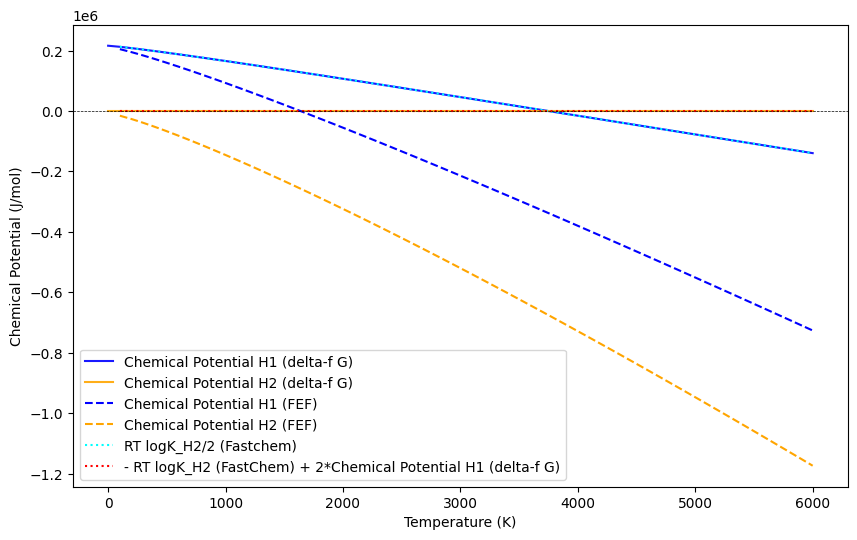

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(T_h_table, mu_h_table, label='Chemical Potential H1 (delta-f G)', color='blue', alpha=0.9)
plt.plot(T_h2_table, mu_h2_table, label='Chemical Potential H2 (delta-f G)', color='orange', alpha=0.9)
plt.plot(T_h_table, mu_fef_h_table, label='Chemical Potential H1 (FEF)', linestyle='--', color='blue')
plt.plot(T_h2_table, mu_fef_h2_table, label='Chemical Potential H2 (FEF)', linestyle='--', color='orange')
plt.plot(T_h_table, 0.5*RTlogk(T_h_table, coeff_h2), label='RT logK_H2/2 (Fastchem)', linestyle=':', color='cyan')
plt.plot(T_h2_table,  - RTlogk(T_h2_table, coeff_h2) + 2*mu_h_table, label='- RT logK_H2 (FastChem) + 2*Chemical Potential H1 (delta-f G)', linestyle=':', color='red')

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Chemical Potential (J/mol)')
plt.legend()

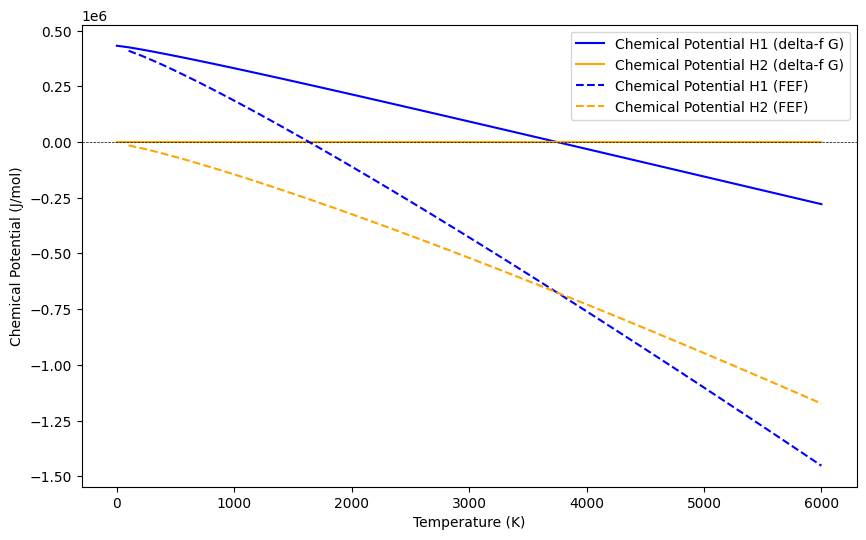

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(T_h_table, 2*mu_h_table , label='Chemical Potential H1 (delta-f G)', color='blue')
plt.plot(T_h2_table, mu_h2_table , label='Chemical Potential H2 (delta-f G)', color='orange')
plt.plot(T_h_table, 2*mu_fef_h_table, label='Chemical Potential H1 (FEF)', linestyle='--', color='blue')
plt.plot(T_h2_table, mu_fef_h2_table, label='Chemical Potential H2 (FEF)', linestyle='--', color='orange')

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Chemical Potential (J/mol)')
plt.legend()

$\mu^\circ_\mathrm{H}(\mathrm{delta-f G}) = \mu^\circ_\mathrm{H} (\mathrm{FEF}) - \frac{1}{2} \mu^\circ_\mathrm{ref} (\mathrm{FEF})$

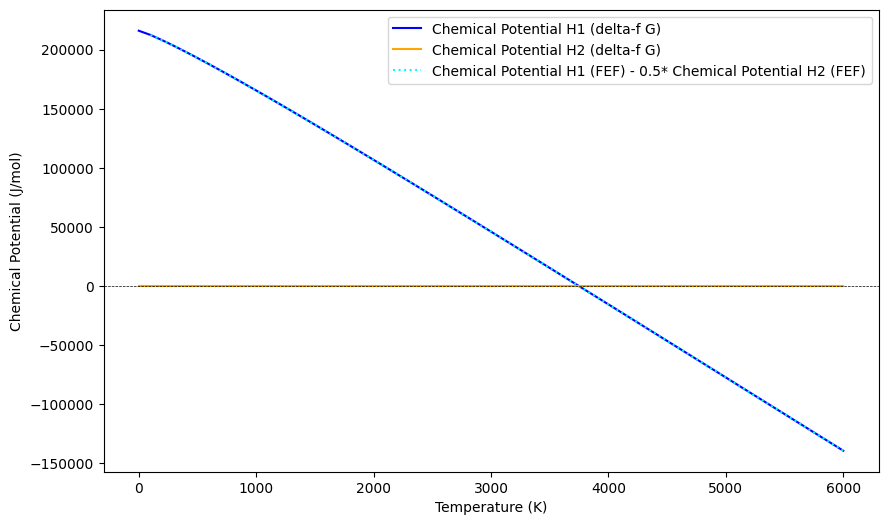

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(T_h_table, mu_h_table , label='Chemical Potential H1 (delta-f G)', color='blue')
plt.plot(T_h2_table, mu_h2_table , label='Chemical Potential H2 (delta-f G)', color='orange')
plt.plot(T_h_table, mu_fef_h_table - 0.5*mu_fef_h2_table, label='Chemical Potential H1 (FEF) - 0.5* Chemical Potential H2 (FEF)', linestyle='dotted', color='cyan')
#plt.plot(T_h2_table, mu_fef_h2_table, label='Chemical Potential H2 (FEF)', linestyle='--', color='orange')

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Chemical Potential (J/mol)')
plt.legend()

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from exogibbs.equilibrium.gibbs import interpolate_hvector_one

In [ ]:
def hv_h(T, mu_h_table_in):
    return interpolate_hvector_one(T, T_h_table, mu_h_table_in)


def hv_h2(T, mu_h2_table_in):
    return interpolate_hvector_one(T, T_h2_table, mu_h2_table_in)


def compute_k(P, T, mu_h_table_in, mu_h2_table_in, Pref=1.0):
    delta_hv = hv_h2(T, mu_h2_table_in) - 2.0 * hv_h(T, mu_h_table_in)
    return np.exp(-delta_hv) * P / Pref

def compute_k_fastchem(P, T, coeff_h2, Pref=1.0): 
    delta_hv = - logk(T, coeff_h2)
    return np.exp(- delta_hv) * P / Pref


Tarr = np.linspace(10.0, 6000.0, 300)
Parr = np.logspace(-8.0, 2.0, 300)


def nh(k):
    return 1.0 / np.sqrt(4.0 * k + 1.0)


def nh2(k):
    return 0.5 * (1.0 - nh(k))


def ntotal(k):
    return nh(k) + nh2(k)


def vmr_h(k):
    return nh(k) / ntotal(k)


def vmr_h2(k):
    return nh2(k) / ntotal(k)

/tmp/ipykernel_8535/4242044453.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(-delta_hv) * P / Pref
/tmp/ipykernel_8535/4242044453.py:23: RuntimeWarning: overflow encountered in multiply
  return 1.0 / np.sqrt(4.0 * k + 1.0)
/tmp/ipykernel_8535/4242044453.py:15: RuntimeWarning: overflow encountered in exp
  return np.exp(- delta_hv) * P / Pref


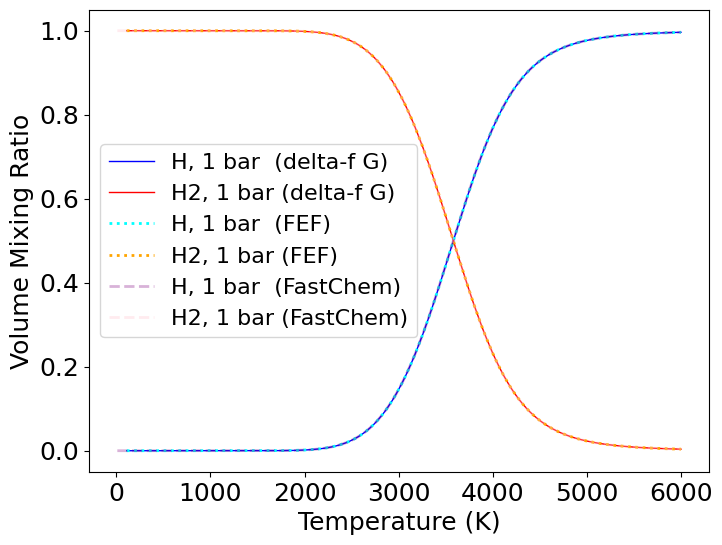

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(Tarr, vmr_h(compute_k(1.0,Tarr, mu_h_table , mu_h2_table)), label='H, 1 bar  (delta-f G)', color='blue', lw=1)
plt.plot(Tarr, vmr_h2(compute_k(1.0,Tarr, mu_h_table , mu_h2_table)), label='H2, 1 bar (delta-f G)', color='red', lw=1)

plt.plot(Tarr, vmr_h(compute_k(1.0,Tarr, mu_fef_h_table, mu_fef_h2_table)), label='H, 1 bar  (FEF)', color='cyan', ls='dotted', lw=2)
plt.plot(Tarr, vmr_h2(compute_k(1.0,Tarr, mu_fef_h_table, mu_fef_h2_table)), label='H2, 1 bar (FEF)', color='orange', ls='dotted', lw=2)

plt.plot(Tarr, vmr_h(compute_k_fastchem(1.0,Tarr, coeff_h2)), label='H, 1 bar  (FastChem)', color='purple', ls='dashed', lw=2, alpha=0.3)
plt.plot(Tarr, vmr_h2(compute_k_fastchem(1.0,Tarr, coeff_h2)), label='H2, 1 bar (FastChem)', color='pink', ls='dashed', lw=2, alpha=0.3)


#plt.xscale('log')
#plt.yscale('log')
#plt.gca().invert_xaxis()
plt.tick_params(labelsize=18)
plt.xlabel("Temperature (K)",fontsize=18)
plt.ylabel('Volume Mixing Ratio', fontsize=18)
plt.legend(fontsize=16, loc='center left')
